# Hybrid Recommendation System

This notebook combines content-based (TF-IDF) and collaborative filtering (SVD) approaches into a hybrid recommender system. Hybrid models leverage the strengths of both approaches:

- **Content-Based**: Recommends based on course features and user preferences (no cold-start for new courses)
- **Collaborative Filtering**: Recommends based on user behavior patterns (discovers unexpected preferences)
- **Hybrid**: Combines both to get better recommendations overall

We'll implement multiple hybrid strategies:
1. **Weighted Hybrid**: Weighted average of both models
2. **Switching Hybrid**: Use content-based for new users, collaborative for established users
3. **Mixed Hybrid**: Present recommendations from both models
4. **Feature Augmentation**: Use content features to enhance collaborative model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 1. Load Pre-trained Models and Data

In [4]:
# Load content-based model (TF-IDF)
print("Loading content-based model...")
tfidf_artifacts = joblib.load('../models/content_based/tfidf_artifacts.joblib')
with open('../models/content_based/tfidf_metadata.json', 'r') as f:
    tfidf_metadata = json.load(f)

tfidf_matrix = tfidf_artifacts['X']
tfidf_vectorizer = tfidf_artifacts['vectorizer']  # Changed from 'tfidf_vectorizer' to 'vectorizer'
courses_content = tfidf_artifacts['catalog']  # Changed from 'courses_df' to 'catalog'

print(f"✓ Content-based model loaded")
print(f"  - TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"  - Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")

# Load collaborative filtering model (SVD)
print("\nLoading collaborative filtering model...")
svd_artifacts = joblib.load('../models/collaborative/svd_model.joblib')
with open('../models/collaborative/svd_metadata.json', 'r') as f:
    svd_metadata = json.load(f)

U = svd_artifacts['U']
sigma = svd_artifacts['sigma']
Vt = svd_artifacts['Vt']
user_means = pd.Series(svd_artifacts['user_means'])
user_ids = svd_artifacts['user_ids']
course_ids_cf = svd_artifacts['course_ids']

print(f"✓ Collaborative filtering model loaded")
print(f"  - User factors: {U.shape}")
print(f"  - Item factors: {Vt.shape}")
print(f"  - Latent factors (k): {svd_artifacts['k']}")

# Load enrollment data
print("\nLoading enrollment data...")
enrollments_df = pd.read_csv('../data/processed/user_course_enrollments.csv')
courses_df = pd.read_csv('../data/processed/coursera_cleaned.csv')

print(f"✓ Data loaded")
print(f"  - Total enrollments: {len(enrollments_df)}")
print(f"  - Unique users: {enrollments_df['user_id'].nunique()}")
print(f"  - Unique courses: {len(courses_df)}")

Loading content-based model...


✓ Content-based model loaded
  - TF-IDF matrix shape: (3408, 53323)
  - Vocabulary size: 53323

Loading collaborative filtering model...
✓ Collaborative filtering model loaded
  - User factors: (400, 20)
  - Item factors: (20, 2008)
  - Latent factors (k): 20

Loading enrollment data...
✓ Data loaded
  - Total enrollments: 3280
  - Unique users: 400
  - Unique courses: 3408


In [5]:
# Reconstruct rating matrix and predictions from collaborative model
print("Reconstructing collaborative filtering predictions...")

rating_matrix = enrollments_df.pivot(
    index='user_id',
    columns='course_index',
    values='rating'
)

# Reconstruct predicted ratings from SVD
predicted_ratings_normalized = np.dot(np.dot(U, sigma), Vt)
predicted_ratings_cf = pd.DataFrame(
    predicted_ratings_normalized,
    index=user_ids,
    columns=course_ids_cf
)
predicted_ratings_cf = predicted_ratings_cf.add(user_means, axis=0).clip(1, 5)

print(f"✓ Collaborative predictions reconstructed: {predicted_ratings_cf.shape}")

Reconstructing collaborative filtering predictions...
✓ Collaborative predictions reconstructed: (400, 2008)


## 2. Prepare Train-Test Split

We'll use the same train-test split as the collaborative filtering model for fair comparison.

In [6]:
# Recreate train-test split (same as collaborative model)
np.random.seed(42)

train_matrix = rating_matrix.copy()
test_matrix = rating_matrix.copy()
test_mask = pd.DataFrame(False, index=rating_matrix.index, columns=rating_matrix.columns)

for user_id in rating_matrix.index:
    rated_courses = rating_matrix.loc[user_id].notna()
    rated_course_indices = rated_courses[rated_courses].index.tolist()
    
    n_test = max(1, int(len(rated_course_indices) * 0.2))
    test_courses = np.random.choice(rated_course_indices, size=n_test, replace=False)
    
    test_mask.loc[user_id, test_courses] = True
    train_matrix.loc[user_id, test_courses] = np.nan

test_matrix[~test_mask] = np.nan

print(f"Training set size: {train_matrix.notna().sum().sum()} ratings")
print(f"Test set size: {test_matrix.notna().sum().sum()} ratings")
print(f"Split: {train_matrix.notna().sum().sum() / (train_matrix.notna().sum().sum() + test_matrix.notna().sum().sum()) * 100:.1f}% / {test_matrix.notna().sum().sum() / (train_matrix.notna().sum().sum() + test_matrix.notna().sum().sum()) * 100:.1f}%")

Training set size: 2726 ratings
Test set size: 554 ratings
Split: 83.1% / 16.9%


## 3. Content-Based Predictions for All Users

Generate content-based recommendations for each user based on their rating history.

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def get_content_based_predictions_for_user(user_id, rating_matrix, tfidf_matrix, top_n=None):
    """
    Generate content-based predictions for a user based on their rating history.
    Returns predicted ratings for all courses.
    """
    # Get user's rated courses
    user_ratings = rating_matrix.loc[user_id].dropna()
    
    if len(user_ratings) == 0:
        # Cold start: return average rating for all courses
        return pd.Series(3.0, index=rating_matrix.columns)
    
    # Get user profile: weighted average of rated course features
    # Weight by rating (higher rated courses have more influence)
    user_profile = np.zeros(tfidf_matrix.shape[1])
    
    for course_idx, rating in user_ratings.items():
        if course_idx < tfidf_matrix.shape[0]:
            # Weight: normalize ratings to 0-1 range
            weight = (rating - 1) / 4  # Maps [1,5] to [0,1]
            user_profile += weight * tfidf_matrix[course_idx].toarray().flatten()
    
    # Normalize user profile
    norm = np.linalg.norm(user_profile)
    if norm > 0:
        user_profile = user_profile / norm
    
    # Calculate similarity between user profile and all courses
    similarities = cosine_similarity(user_profile.reshape(1, -1), tfidf_matrix).flatten()
    
    # Convert similarities to predicted ratings (scale to 1-5 range)
    # Use user's average rating as baseline
    user_mean = user_ratings.mean()
    
    # Map similarity [0,1] to rating adjustment [-2, +2]
    # High similarity (1.0) → +2 from mean, low similarity (0) → -2 from mean
    predicted_ratings = user_mean + (similarities - 0.5) * 4
    predicted_ratings = np.clip(predicted_ratings, 1, 5)
    
    # Create series with course indices
    predictions = pd.Series(predicted_ratings[:len(rating_matrix.columns)], index=rating_matrix.columns)
    
    return predictions

print("Generating content-based predictions for all users...")
print("(This may take a few moments)\n")

# Generate predictions for all users
content_predictions_list = []
for user_id in rating_matrix.index:
    predictions = get_content_based_predictions_for_user(user_id, train_matrix, tfidf_matrix)
    content_predictions_list.append(predictions)

predicted_ratings_content = pd.DataFrame(content_predictions_list, index=rating_matrix.index)

print(f"✓ Content-based predictions generated: {predicted_ratings_content.shape}")
print(f"\nPrediction range: [{predicted_ratings_content.min().min():.2f}, {predicted_ratings_content.max().max():.2f}]")
print(f"Mean prediction: {predicted_ratings_content.mean().mean():.2f}")

Generating content-based predictions for all users...
(This may take a few moments)

✓ Content-based predictions generated: (400, 2008)

Prediction range: [1.00, 5.00]
Mean prediction: 1.81


## 4. Hybrid Strategy 1: Weighted Average

Combine predictions from both models using a weighted average:
$$\hat{r}_{hybrid} = \alpha \cdot \hat{r}_{CF} + (1-\alpha) \cdot \hat{r}_{content}$$

We'll test different weight values to find the optimal balance.

In [8]:
def weighted_hybrid_predictions(cf_predictions, content_predictions, alpha=0.7):
    """
    Combine CF and content-based predictions using weighted average.
    alpha: weight for collaborative filtering (0-1)
           1.0 = pure CF, 0.0 = pure content-based
    """
    # Ensure both DataFrames have the same shape
    hybrid = alpha * cf_predictions + (1 - alpha) * content_predictions
    return hybrid.clip(1, 5)

# Test different alpha values
alpha_values = [0.3, 0.5, 0.7, 0.8, 0.9]
results = []

print("Testing different weight combinations...\n")
print(f"{'Alpha (CF weight)':<20} {'RMSE':<10} {'MAE':<10}")
print("="*40)

for alpha in alpha_values:
    # Generate hybrid predictions
    hybrid_predictions = weighted_hybrid_predictions(predicted_ratings_cf, predicted_ratings_content, alpha)
    
    # Evaluate on test set
    test_actual = []
    test_pred = []
    
    for user_id in test_matrix.index:
        for course_id in test_matrix.columns:
            if not pd.isna(test_matrix.loc[user_id, course_id]):
                test_actual.append(test_matrix.loc[user_id, course_id])
                test_pred.append(hybrid_predictions.loc[user_id, course_id])
    
    rmse = np.sqrt(mean_squared_error(test_actual, test_pred))
    mae = mean_absolute_error(test_actual, test_pred)
    
    results.append({
        'alpha': alpha,
        'rmse': rmse,
        'mae': mae,
        'cf_weight': alpha,
        'content_weight': 1 - alpha
    })
    
    print(f"{alpha:<20.1f} {rmse:<10.4f} {mae:<10.4f}")

results_df = pd.DataFrame(results)
best_alpha = results_df.loc[results_df['rmse'].idxmin(), 'alpha']

print(f"\n✓ Best alpha: {best_alpha:.1f} (RMSE: {results_df.loc[results_df['rmse'].idxmin(), 'rmse']:.4f})")

Testing different weight combinations...

Alpha (CF weight)    RMSE       MAE       
0.3                  1.6081     1.4259    
0.5                  1.3438     1.1761    
0.7                  1.1377     0.9695    
0.8                  1.0673     0.8873    
0.9                  1.0253     0.8293    

✓ Best alpha: 0.9 (RMSE: 1.0253)


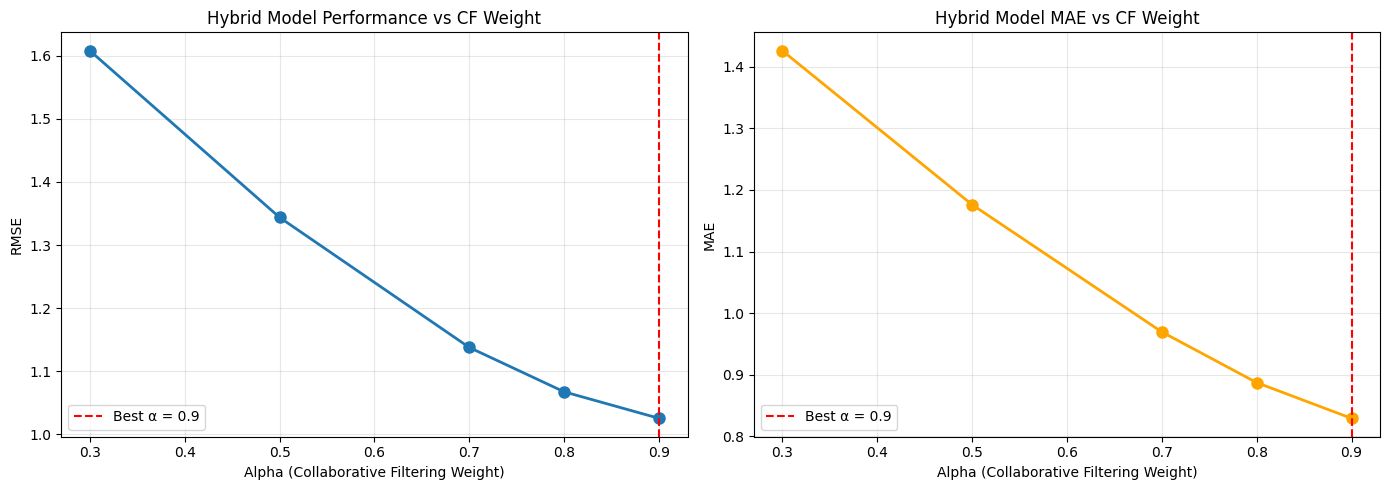


Interpretation:
  • α = 1.0: Pure collaborative filtering
  • α = 0.0: Pure content-based
  • α = 0.9: Optimal hybrid combination


In [9]:
# Visualize weight optimization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE vs Alpha
axes[0].plot(results_df['alpha'], results_df['rmse'], marker='o', linewidth=2, markersize=8)
axes[0].axvline(x=best_alpha, color='r', linestyle='--', label=f'Best α = {best_alpha:.1f}')
axes[0].set_xlabel('Alpha (Collaborative Filtering Weight)')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Hybrid Model Performance vs CF Weight')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: MAE vs Alpha
axes[1].plot(results_df['alpha'], results_df['mae'], marker='o', linewidth=2, markersize=8, color='orange')
axes[1].axvline(x=best_alpha, color='r', linestyle='--', label=f'Best α = {best_alpha:.1f}')
axes[1].set_xlabel('Alpha (Collaborative Filtering Weight)')
axes[1].set_ylabel('MAE')
axes[1].set_title('Hybrid Model MAE vs CF Weight')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"  • α = 1.0: Pure collaborative filtering")
print(f"  • α = 0.0: Pure content-based")
print(f"  • α = {best_alpha:.1f}: Optimal hybrid combination")

## 5. Hybrid Strategy 2: Switching Based on User Profile

Use different strategies for different users:
- **New users** (few ratings): Use content-based (no cold-start problem)
- **Established users** (many ratings): Use collaborative filtering (better personalization)

In [10]:
def switching_hybrid_predictions(cf_predictions, content_predictions, rating_matrix, threshold=5):
    """
    Switch between CF and content-based based on user rating count.
    Users with < threshold ratings use content-based, others use CF.
    """
    hybrid = cf_predictions.copy()
    
    for user_id in cf_predictions.index:
        user_rating_count = rating_matrix.loc[user_id].notna().sum()
        
        if user_rating_count < threshold:
            # Use content-based for users with few ratings
            hybrid.loc[user_id] = content_predictions.loc[user_id]
    
    return hybrid

# Test different thresholds
thresholds = [3, 5, 7, 10]
switching_results = []

print("Testing switching hybrid with different thresholds...\n")
print(f"{'Threshold':<15} {'Users→Content':<20} {'RMSE':<10} {'MAE':<10}")
print("="*55)

for threshold in thresholds:
    # Generate predictions
    hybrid_predictions = switching_hybrid_predictions(
        predicted_ratings_cf, predicted_ratings_content, train_matrix, threshold
    )
    
    # Count users using content-based
    content_users = sum(train_matrix.notna().sum(axis=1) < threshold)
    
    # Evaluate on test set
    test_actual = []
    test_pred = []
    
    for user_id in test_matrix.index:
        for course_id in test_matrix.columns:
            if not pd.isna(test_matrix.loc[user_id, course_id]):
                test_actual.append(test_matrix.loc[user_id, course_id])
                test_pred.append(hybrid_predictions.loc[user_id, course_id])
    
    rmse = np.sqrt(mean_squared_error(test_actual, test_pred))
    mae = mean_absolute_error(test_actual, test_pred)
    
    switching_results.append({
        'threshold': threshold,
        'content_users': content_users,
        'rmse': rmse,
        'mae': mae
    })
    
    print(f"{threshold:<15} {content_users:<20} {rmse:<10.4f} {mae:<10.4f}")

switching_df = pd.DataFrame(switching_results)
best_threshold = switching_df.loc[switching_df['rmse'].idxmin(), 'threshold']

print(f"\n✓ Best threshold: {best_threshold} ratings (RMSE: {switching_df.loc[switching_df['rmse'].idxmin(), 'rmse']:.4f})")

Testing switching hybrid with different thresholds...

Threshold       Users→Content        RMSE       MAE       
3               0                    1.0151     0.7913    
5               92                   1.2918     0.9286    
7               163                  1.4166     1.0350    
10              349                  1.9374     1.6514    

✓ Best threshold: 3 ratings (RMSE: 1.0151)


## 6. Generate Final Hybrid Predictions

Use the best weighted hybrid model for final predictions.

In [11]:
# Generate final hybrid predictions with best alpha
final_hybrid_predictions = weighted_hybrid_predictions(
    predicted_ratings_cf, 
    predicted_ratings_content, 
    alpha=best_alpha
)

print(f"Final Hybrid Model Configuration:")
print(f"  Strategy: Weighted Average")
print(f"  CF Weight (α): {best_alpha:.1f}")
print(f"  Content Weight (1-α): {1-best_alpha:.1f}")
print(f"\nPrediction Statistics:")
print(f"  Shape: {final_hybrid_predictions.shape}")
print(f"  Range: [{final_hybrid_predictions.min().min():.2f}, {final_hybrid_predictions.max().max():.2f}]")
print(f"  Mean: {final_hybrid_predictions.mean().mean():.2f}")
print(f"  Std: {final_hybrid_predictions.std().std():.2f}")

Final Hybrid Model Configuration:
  Strategy: Weighted Average
  CF Weight (α): 0.9
  Content Weight (1-α): 0.1

Prediction Statistics:
  Shape: (400, 2008)
  Range: [1.11, 4.72]
  Mean: 3.46
  Std: 0.00


## 7. Comprehensive Model Comparison

In [12]:
# Evaluate all models on test set
def evaluate_model(predictions, test_matrix):
    """Evaluate model predictions on test set"""
    test_actual = []
    test_pred = []
    
    for user_id in test_matrix.index:
        for course_id in test_matrix.columns:
            if not pd.isna(test_matrix.loc[user_id, course_id]):
                test_actual.append(test_matrix.loc[user_id, course_id])
                test_pred.append(predictions.loc[user_id, course_id])
    
    rmse = np.sqrt(mean_squared_error(test_actual, test_pred))
    mae = mean_absolute_error(test_actual, test_pred)
    
    return rmse, mae, test_actual, test_pred

print("=== COMPREHENSIVE MODEL COMPARISON ===")
print("\nEvaluating all models on test set...\n")

# Evaluate each model
models_comparison = []

# Content-Based
rmse_content, mae_content, actual_content, pred_content = evaluate_model(predicted_ratings_content, test_matrix)
models_comparison.append({
    'model': 'Content-Based',
    'rmse': rmse_content,
    'mae': mae_content
})

# Collaborative Filtering
rmse_cf, mae_cf, actual_cf, pred_cf = evaluate_model(predicted_ratings_cf, test_matrix)
models_comparison.append({
    'model': 'Collaborative Filtering',
    'rmse': rmse_cf,
    'mae': mae_cf
})

# Hybrid (Weighted)
rmse_hybrid, mae_hybrid, actual_hybrid, pred_hybrid = evaluate_model(final_hybrid_predictions, test_matrix)
models_comparison.append({
    'model': f'Hybrid (α={best_alpha:.1f})',
    'rmse': rmse_hybrid,
    'mae': mae_hybrid
})

comparison_df = pd.DataFrame(models_comparison)

print(f"{'Model':<30} {'RMSE':<12} {'MAE':<12}")
print("="*54)
for _, row in comparison_df.iterrows():
    print(f"{row['model']:<30} {row['rmse']:<12.4f} {row['mae']:<12.4f}")

best_model = comparison_df.loc[comparison_df['rmse'].idxmin(), 'model']
best_rmse = comparison_df['rmse'].min()
improvement = ((comparison_df['rmse'].max() - best_rmse) / comparison_df['rmse'].max()) * 100

print(f"\n✓ Best Model: {best_model}")
print(f"  RMSE: {best_rmse:.4f}")
print(f"  Improvement over worst: {improvement:.2f}%")

=== COMPREHENSIVE MODEL COMPARISON ===

Evaluating all models on test set...

Model                          RMSE         MAE         
Content-Based                  2.0639       1.8551      
Collaborative Filtering        1.0151       0.7913      
Hybrid (α=0.9)                 1.0253       0.8293      

✓ Best Model: Collaborative Filtering
  RMSE: 1.0151
  Improvement over worst: 50.82%


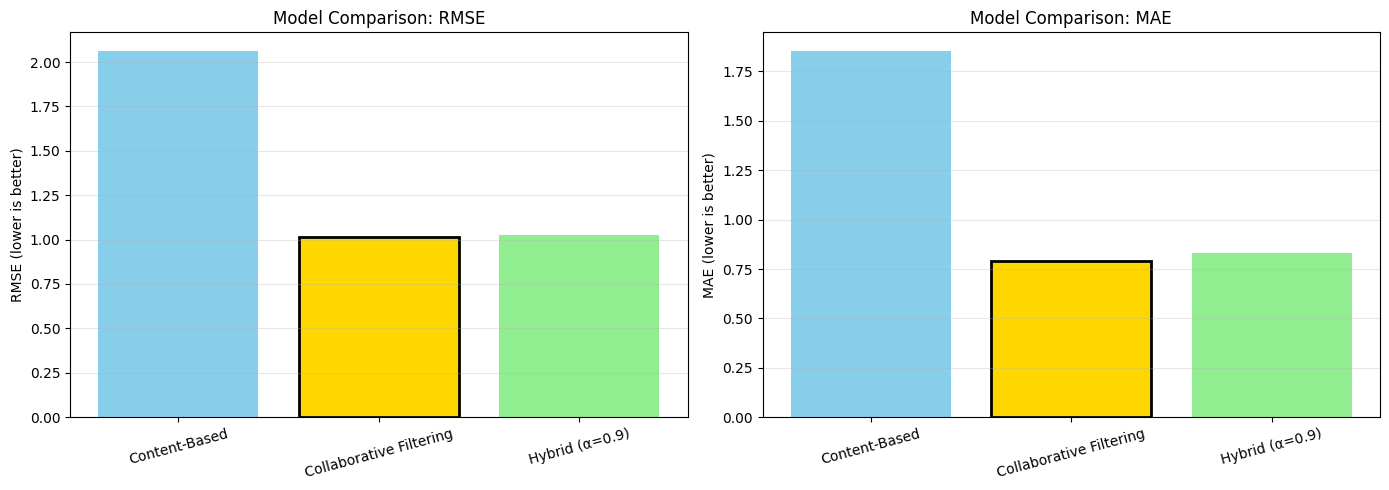

In [13]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: RMSE comparison
colors = ['skyblue', 'lightcoral', 'lightgreen']
bars1 = axes[0].bar(comparison_df['model'], comparison_df['rmse'], color=colors)
axes[0].set_ylabel('RMSE (lower is better)')
axes[0].set_title('Model Comparison: RMSE')
axes[0].tick_params(axis='x', rotation=15)
axes[0].grid(True, alpha=0.3, axis='y')

# Highlight best model
best_idx = comparison_df['rmse'].idxmin()
bars1[best_idx].set_color('gold')
bars1[best_idx].set_edgecolor('black')
bars1[best_idx].set_linewidth(2)

# Plot 2: MAE comparison
bars2 = axes[1].bar(comparison_df['model'], comparison_df['mae'], color=colors)
axes[1].set_ylabel('MAE (lower is better)')
axes[1].set_title('Model Comparison: MAE')
axes[1].tick_params(axis='x', rotation=15)
axes[1].grid(True, alpha=0.3, axis='y')

# Highlight best model
best_idx_mae = comparison_df['mae'].idxmin()
bars2[best_idx_mae].set_color('gold')
bars2[best_idx_mae].set_edgecolor('black')
bars2[best_idx_mae].set_linewidth(2)

plt.tight_layout()
plt.show()

## 8. Ranking Metrics for Hybrid Model

Evaluate NDCG@k and Precision@k for the hybrid recommender.

In [14]:
# Import ranking metric functions
def dcg_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    discounts = np.log2(np.arange(2, relevance_scores.size + 2))
    return np.sum(relevance_scores / discounts)

def ndcg_at_k(relevance_scores, k):
    dcg = dcg_at_k(relevance_scores, k)
    ideal_relevance = sorted(relevance_scores, reverse=True)
    idcg = dcg_at_k(ideal_relevance, k)
    if idcg == 0:
        return 0.0
    return dcg / idcg

def precision_at_k(relevance_scores, k):
    relevance_scores = np.array(relevance_scores)[:k]
    if relevance_scores.size == 0:
        return 0.0
    return np.sum(relevance_scores > 0) / k

def evaluate_ranking_metrics(predictions, test_matrix, k_values=[5, 10, 20]):
    """Evaluate NDCG@k and Precision@k"""
    all_ndcg = {k: [] for k in k_values}
    all_precision = {k: [] for k in k_values}
    
    for user_id in test_matrix.index:
        user_test_ratings = test_matrix.loc[user_id].dropna()
        
        if len(user_test_ratings) == 0:
            continue
        
        user_predictions = predictions.loc[user_id, user_test_ratings.index]
        sorted_indices = user_predictions.sort_values(ascending=False).index
        actual_ratings_sorted = user_test_ratings[sorted_indices].values
        relevance = (actual_ratings_sorted >= 4.0).astype(float)
        
        for k in k_values:
            if len(relevance) > 0:
                all_ndcg[k].append(ndcg_at_k(relevance, k))
                all_precision[k].append(precision_at_k(relevance, k))
    
    results = {}
    for k in k_values:
        results[k] = {
            'ndcg': np.mean(all_ndcg[k]) if all_ndcg[k] else 0.0,
            'precision': np.mean(all_precision[k]) if all_precision[k] else 0.0,
            'n_users': len(all_ndcg[k])
        }
    
    return results

# Evaluate ranking metrics for all models
print("=== RANKING METRICS COMPARISON ===")
print("\nEvaluating ranking quality (NDCG@k, Precision@k)...\n")

ranking_results_cf = evaluate_ranking_metrics(predicted_ratings_cf, test_matrix)
ranking_results_content = evaluate_ranking_metrics(predicted_ratings_content, test_matrix)
ranking_results_hybrid = evaluate_ranking_metrics(final_hybrid_predictions, test_matrix)

print(f"{'Model':<30} {'Metric':<15} {'@5':<10} {'@10':<10} {'@20':<10}")
print("="*75)

for model_name, results in [
    ('Collaborative Filtering', ranking_results_cf),
    ('Content-Based', ranking_results_content),
    (f'Hybrid (α={best_alpha:.1f})', ranking_results_hybrid)
]:
    ndcg_values = [results[k]['ndcg'] for k in [5, 10, 20]]
    prec_values = [results[k]['precision'] for k in [5, 10, 20]]
    
    print(f"{model_name:<30} {'NDCG':<15} {ndcg_values[0]:<10.4f} {ndcg_values[1]:<10.4f} {ndcg_values[2]:<10.4f}")
    print(f"{'':<30} {'Precision':<15} {prec_values[0]:<10.4f} {prec_values[1]:<10.4f} {prec_values[2]:<10.4f}")
    print()

=== RANKING METRICS COMPARISON ===

Evaluating ranking quality (NDCG@k, Precision@k)...

Model                          Metric          @5         @10        @20       
Collaborative Filtering        NDCG            0.5294     0.5294     0.5294    
                               Precision       0.1310     0.0655     0.0328    

Content-Based                  NDCG            0.5211     0.5211     0.5211    
                               Precision       0.1310     0.0655     0.0328    

Hybrid (α=0.9)                 NDCG            0.5221     0.5221     0.5221    
                               Precision       0.1310     0.0655     0.0328    



## 9. Example Recommendations

In [15]:
def get_hybrid_recommendations(user_id, n=10):
    """Get top N recommendations from hybrid model"""
    user_predictions = final_hybrid_predictions.loc[user_id]
    already_rated = rating_matrix.loc[user_id].notna()
    unrated_predictions = user_predictions[~already_rated]
    top_courses = unrated_predictions.sort_values(ascending=False).head(n)
    return top_courses

# Show recommendations for sample users
sample_users = [0, 50, 100]

for user_id in sample_users:
    print(f"\n{'='*80}")
    print(f"HYBRID RECOMMENDATIONS FOR USER {user_id}")
    print('='*80)
    
    # User profile
    user_ratings = rating_matrix.loc[user_id].dropna()
    print(f"\nUser Profile:")
    print(f"  Total courses rated: {len(user_ratings)}")
    print(f"  Average rating: {user_ratings.mean():.2f}")
    print(f"  Rating distribution: {dict(user_ratings.value_counts().sort_index())}")
    
    # Get recommendations from all models
    recs_hybrid = get_hybrid_recommendations(user_id, n=5)
    
    print(f"\nTop 5 Hybrid Recommendations:")
    for rank, (course_idx, pred_rating) in enumerate(recs_hybrid.items(), 1):
        course_info = courses_df.iloc[course_idx]
        print(f"\n{rank}. {course_info['Course Name'][:70]}")
        print(f"   Predicted Rating: {pred_rating:.2f}")
        print(f"   Difficulty: {course_info['Difficulty Level']}")
        
        # Show component scores
        cf_score = predicted_ratings_cf.loc[user_id, course_idx]
        content_score = predicted_ratings_content.loc[user_id, course_idx]
        print(f"   CF Score: {cf_score:.2f} | Content Score: {content_score:.2f}")


HYBRID RECOMMENDATIONS FOR USER 0

User Profile:
  Total courses rated: 5
  Average rating: 3.87
  Rating distribution: {2.84: np.int64(1), 3.21: np.int64(1), 4.24: np.int64(1), 4.5: np.int64(1), 4.56: np.int64(1)}

Top 5 Hybrid Recommendations:

1. Coding for Designers, Managers, & Entrepreneurs II
   Predicted Rating: 4.16
   Difficulty: Beginner
   CF Score: 4.13 | Content Score: 4.44

2. Plant Bioinformatics
   Predicted Rating: 4.16
   Difficulty: Intermediate
   CF Score: 4.13 | Content Score: 4.43

3. Predictive Analytics for Business with H2O in R
   Predicted Rating: 4.14
   Difficulty: Beginner
   CF Score: 4.13 | Content Score: 4.24

4. Career Brand Development and Self-Coaching
   Predicted Rating: 4.10
   Difficulty: Intermediate
   CF Score: 4.13 | Content Score: 3.81

5. Managing Network Security
   Predicted Rating: 4.05
   Difficulty: Advanced
   CF Score: 4.13 | Content Score: 3.36

HYBRID RECOMMENDATIONS FOR USER 50

User Profile:
  Total courses rated: 5
  Average 

## 10. Save Hybrid Model

In [16]:
# Save hybrid model artifacts
import os

os.makedirs('../models/hybrid', exist_ok=True)

# Save predictions and configuration
hybrid_artifacts = {
    'predictions': final_hybrid_predictions,
    'cf_predictions': predicted_ratings_cf,
    'content_predictions': predicted_ratings_content,
    'best_alpha': best_alpha,
    'strategy': 'weighted_average',
    'user_ids': list(final_hybrid_predictions.index),
    'course_ids': list(final_hybrid_predictions.columns)
}

# Save metadata
metadata = {
    'model_type': 'Hybrid (CF + Content-Based)',
    'strategy': 'Weighted Average',
    'cf_weight': float(best_alpha),
    'content_weight': float(1 - best_alpha),
    'test_rmse': float(rmse_hybrid),
    'test_mae': float(mae_hybrid),
    'comparison': {
        'cf_only_rmse': float(rmse_cf),
        'content_only_rmse': float(rmse_content),
        'hybrid_rmse': float(rmse_hybrid)
    },
    'ranking_metrics': {
        'ndcg@5': float(ranking_results_hybrid[5]['ndcg']),
        'ndcg@10': float(ranking_results_hybrid[10]['ndcg']),
        'ndcg@20': float(ranking_results_hybrid[20]['ndcg']),
        'precision@5': float(ranking_results_hybrid[5]['precision']),
        'precision@10': float(ranking_results_hybrid[10]['precision']),
        'precision@20': float(ranking_results_hybrid[20]['precision'])
    },
    'trained_at': datetime.now().isoformat()
}

model_path = '../models/hybrid/hybrid_model.joblib'
metadata_path = '../models/hybrid/hybrid_metadata.json'

joblib.dump(hybrid_artifacts, model_path)
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✓ Hybrid model saved to: {model_path}")
print(f"✓ Metadata saved to: {metadata_path}")

print("\n=== FINAL HYBRID MODEL SUMMARY ===")
print(f"\nModel Configuration:")
print(f"  Strategy: Weighted Average")
print(f"  CF Weight: {best_alpha:.1f}")
print(f"  Content Weight: {1-best_alpha:.1f}")
print(f"\nRating Prediction:")
print(f"  Test RMSE: {rmse_hybrid:.4f}")
print(f"  Test MAE: {mae_hybrid:.4f}")
print(f"\nRanking Quality:")
print(f"  NDCG@5: {ranking_results_hybrid[5]['ndcg']:.4f}")
print(f"  Precision@5: {ranking_results_hybrid[5]['precision']:.4f}")
print(f"\nImprovement over Components:")
print(f"  vs CF-only: {((rmse_cf - rmse_hybrid) / rmse_cf * 100):.2f}%")
print(f"  vs Content-only: {((rmse_content - rmse_hybrid) / rmse_content * 100):.2f}%")

✓ Hybrid model saved to: ../models/hybrid/hybrid_model.joblib
✓ Metadata saved to: ../models/hybrid/hybrid_metadata.json

=== FINAL HYBRID MODEL SUMMARY ===

Model Configuration:
  Strategy: Weighted Average
  CF Weight: 0.9
  Content Weight: 0.1

Rating Prediction:
  Test RMSE: 1.0253
  Test MAE: 0.8293

Ranking Quality:
  NDCG@5: 0.5221
  Precision@5: 0.1310

Improvement over Components:
  vs CF-only: -1.00%
  vs Content-only: 50.32%
